## Visualizing the distribution of the observations

### initialzation
* Load the required libraries
* peak data samples

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SSSBSBBB'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12930
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1368.2| 39.6372|-119.7094|       TMAX|USC00267691|     7|[80 4D 90 55 80 5...|2010.0|SSSBSBBB|
|   1368.2| 39.6372|-119.7094|       TMIN|USC00267691|    10|[A0 D3 80 D4 90 D...|2010.0|SSSBSBBB|
|   1369.5| 39.5333|-119.8167|       TMAX|USC00266782|    32|[80 54 30 55 90 5...|1893.0|SSSBSBBB|
|   1369.5| 39.5333|-119.8167|       TMAX|USC00266782|     0|[40 56 90 55 80 5...|1896.0|SSSBSBBB|
|   1369.5| 39.5333|-119.8167|       TMAX|USC00266782|     4|[30 55 90 55 30 5...|1897.0|SSSBSBBB|
+---------+--------+---------+-----------+-----------+------+-------------

In [2]:
sqlContext.registerDataFrameAsTable(df,'weather')
# check locations of the dataset from latitude,longitude
queryx="SELECT station,latitude,longitude,elevation,count(*) as count FROM weather GROUP BY station,latitude,longitude,elevation ORDER BY count DESC"
dfx = sqlContext.sql(queryx)
dfx.show()

+-----------+--------+---------+---------+-----+
|    station|latitude|longitude|elevation|count|
+-----------+--------+---------+---------+-----+
|USC00046136| 39.2467|-121.0008|    847.6|  567|
|USC00048758| 39.1678|-120.1428|   1898.9|  533|
|USC00261485| 39.1464|-119.7678|   1417.6|  481|
|USC00262780| 39.4572|-118.7811|   1208.5|  468|
|USC00041912| 39.0911|-120.9481|    725.4|  448|
|USC00260507| 39.4931|-117.0675|   2066.5|  426|
|USC00047085| 39.8053|-120.4719|   1478.3|  417|
|USC00049043| 39.3331| -120.173|   1774.9|  416|
|USC00044713| 39.3183|-120.6392|   1571.5|  404|
|USC00264349| 39.4689|-119.0644|   1270.1|  400|
|USC00040931| 39.3886|-120.0936|   1699.3|  395|
|USC00262708| 39.5169|-115.9622|   1959.9|  379|
|USC00042500| 39.5633|-120.8239|    888.5|  373|
|USC00048218| 39.5833|-120.3706|   1516.4|  363|
|USW00023185| 39.4839|-119.7711|   1344.2|  357|
|USC00041018| 39.4539|-120.6556|   1641.3|  349|
|USC00042467| 39.3239|-120.2331|   1809.6|  309|
|USC00268761| 39.312

### Peek data for a particular station(USC00046136)
* The station has most measurement within the dataset
* Make a yearly plot for all 6 measurements

measurement TMIN has 103 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1898.9| 39.1678|-120.1428|       TMIN|USC00048758|     8|[E0 D5 E0 D8 98 D...|1910.0|SSSBSBBB|
|   1898.9| 39.1678|-120.1428|       TMIN|USC00048758|     3|[E0 D4 E0 D5 80 D...|1911.0|SSSBSBBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows

measurement TOBS has 69 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1898.9| 39.1678|-120.

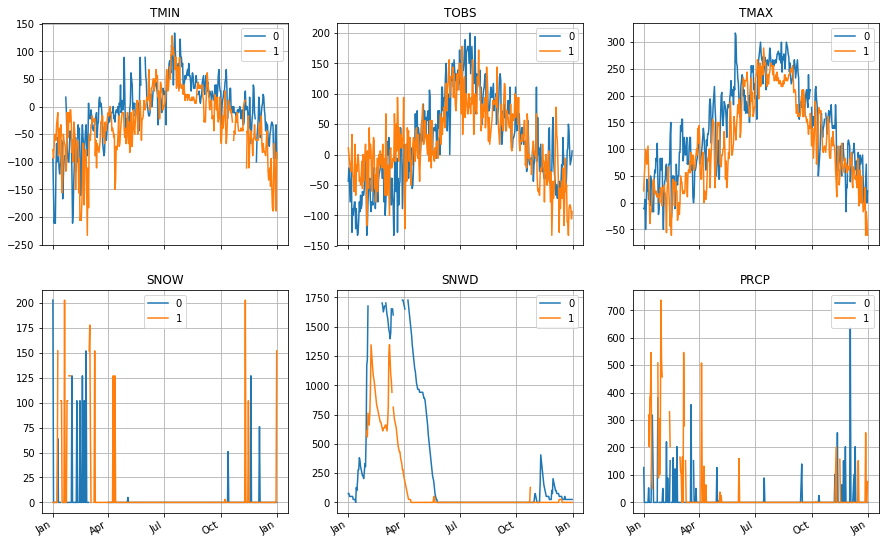

In [3]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(2,3, figsize=(15,10));

for i,mea in enumerate(STAT.keys()):
    sqlContext.registerDataFrameAsTable(df,'weather')
    Query="SELECT * FROM weather WHERE station='%s' AND measurement='%s'"%('USC00048758', mea)
    df1 = sqlContext.sql(Query)
    row_count = df1.count()
    print 'measurement %s has %d rows' % (mea, row_count)
    if row_count > 0:
        df1.show(2)
        rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
        T=np.vstack(rows)
        #T=T/10.  # scaling to make the temperature be in centingrates
        #plotting yearly plots
        YP=YearPlotter()
        YP.plot(T[:2,:].transpose(),fig,ax[i/3,i%3],title=mea)
plt.show()


### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [4]:
def plot_all_measures(func):
    fig,ax=subplots(2,3,figsize=(15,10))
    for i,mea in enumerate(STAT.keys()):
        axis = ax[i/3, i%3]
        func(mea,fig,axis)

def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

c:\Users\wenyan\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


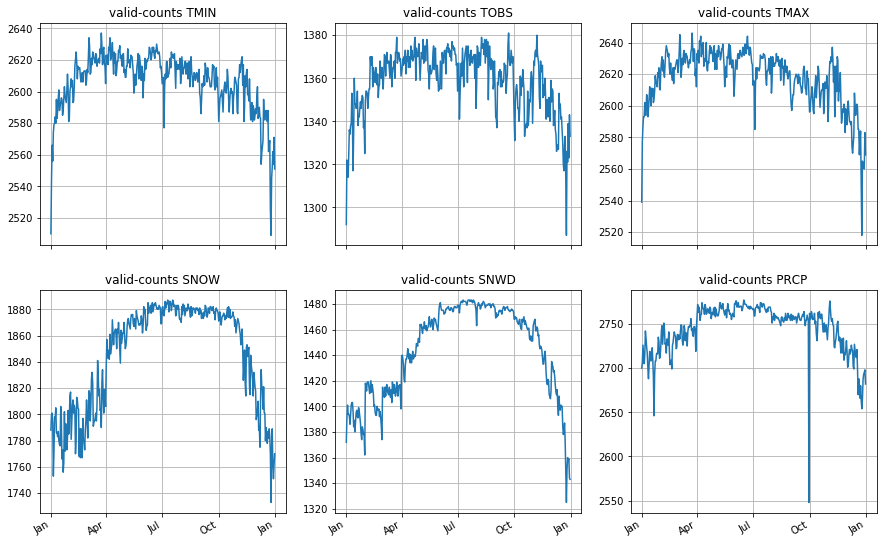

In [5]:
plot_all_measures(plot_valid)

In [ ]:
Plot TMIN,TMAX

In [22]:
def plot_multi_measures(meas,fig,axis):
    stats = []
    for m in meas:
        if m in ['TMIN','TOBS','TMAX']:
            mean=STAT[m]['Mean']/10*1.8 + 32  # Centigrade to Fahrenheit 
        else:
            mean=STAT[m]['Mean']
        stats.append(mean)
    graphs=np.vstack(stats).transpose()
    YP.plot(graphs,fig,axis,title='+'.join(meas),labels=meas)

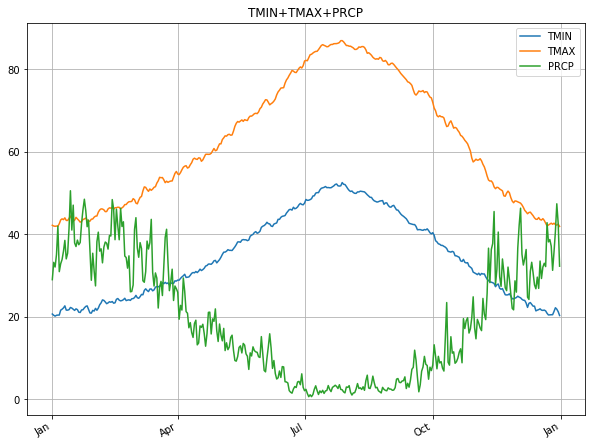

In [25]:
fig,ax = plt.subplots(1,1,figsize=(10,8))
plot_multi_measures(['TMIN','TMAX','PRCP'],fig,ax)

plt.show()

### Plots of mean and std of observations

In [6]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m)

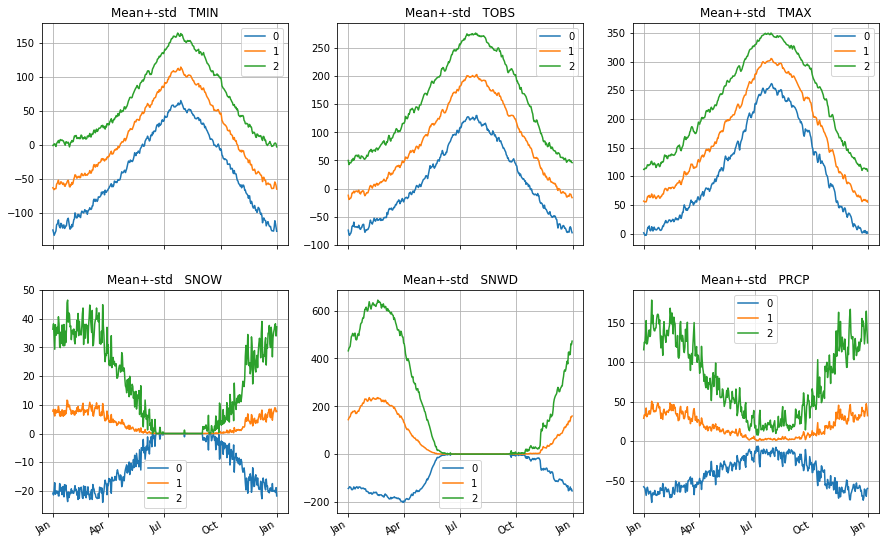

In [7]:
plot_all_measures(plot_mean_std)

### plotting top 3 eigenvectors

In [32]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

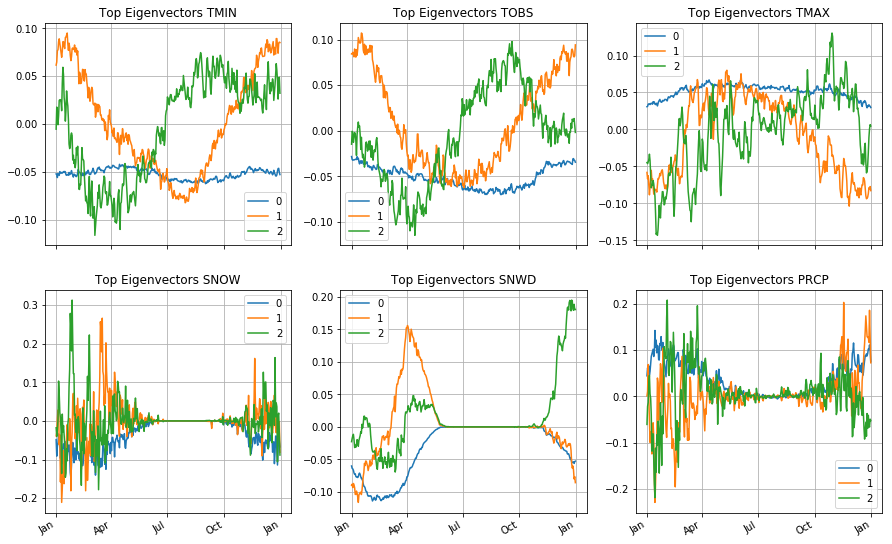

In [33]:
plot_all_measures(plot_eigen)

### Script for plotting percentage of variance explained

In [22]:
def plt_var_explained(m,fig,ax):
    EV=STAT[m]['eigval']
    k=5
    ax.plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    ax.set_title('Percentage of Variance Explained for '+ m)
    ax.set_ylabel('Percentage of Variance')
    ax.set_xlabel('# Eigenvector')
    ax.grid()
    

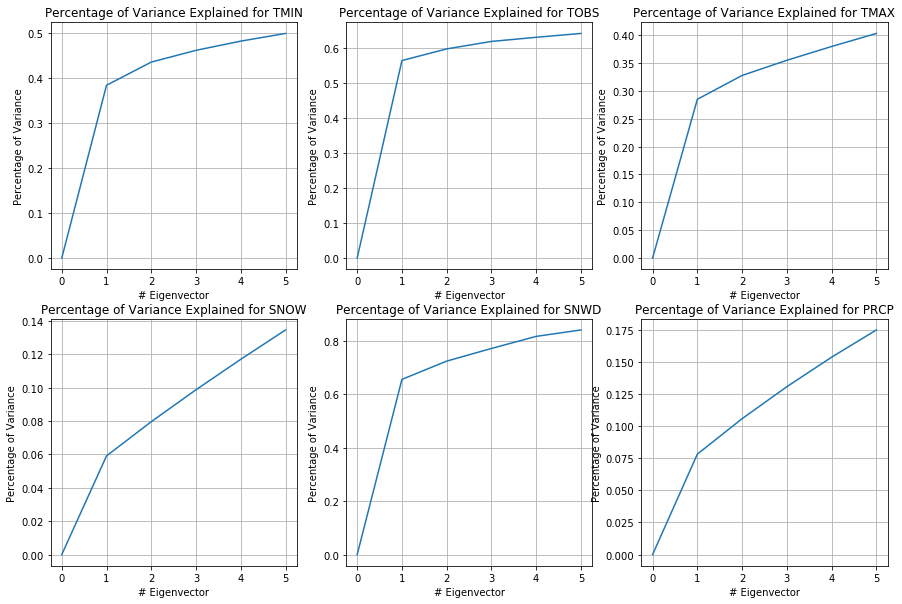

In [23]:
plot_all_measures(plt_var_explained)

In [19]:
#sc.stop()